In [1]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image
import numpy as np
import glob
from tqdm import tqdm

/home/mila/v/venkatesh.ramesh/.conda/envs/ds/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating masked label m_i

In [125]:
image_path = '/home/mila/v/venkatesh.ramesh/scratch/Tree-Monitoring/hloss_imgs/images/'
label_path = '/home/mila/v/venkatesh.ramesh/scratch/Tree-Monitoring/hloss_imgs/labels/'
masks_path = '/home/mila/v/venkatesh.ramesh/scratch/Tree-Monitoring/hloss_imgs/masks/'

In [126]:
label_list = glob.glob(label_path + '/**/*.png', recursive=True)

In [14]:
species_level = {"ABBA": 3, "ACPE": 3, "ACRU": 3, "ACSA": 3, "Acer": 2, "BEAL": 3, "BEPA": 3, "BEPO": 3, "Betula": 2, "Conifere": 1, "FAGR": 3, "FRNI": 3, "Feuillus": 1, "LALA": 3, "PIGL": 3, "PIMA": 3, "PIRU": 3, "PIST": 3, "POBA": 3, "POGR": 3, "POTR": 3, "PRPE": 3, "Picea": 2, "Populus": 2, "QURU": 3, "THOC": 3, "TSCA": 3, "OSVI": 3, "Mort": 3}

#1: Class-level
#2: Genus
#3: Species

In [15]:
myriam_classes = {"ABBA": 1, "ACPE": 2, "ACRU": 3, "ACSA": 4, "BEAL": 5, "BEPA": 6, "FAGR": 7, "LALA": 8, "Mort": 9, "PIST": 10, "Picea": 11, "Populus": 12, "THOC": 13, "TSCA": 14}

In [16]:
species_id_level = {}
for k in myriam_classes:
    species_id_level[myriam_classes[k]] = species_level[k]
#     print(k, all_species[k])

In [17]:
# species_id_level

In [18]:
def three_level_image(path):
    img = np.array(Image.open(path))
    for id in species_id_level:
#         print(id, species_id_level[id])
        img[img == id] = species_id_level[id]
    return Image.fromarray(img)

In [19]:
# # for item in label_list:
# z = three_level_image('/home/mila/v/venkatesh.ramesh/scratch/Tree-Monitoring/hloss_imgs/labels/1234961_1492330.png')
# z.save('/home/mila/v/venkatesh.ramesh/scratch/Tree-Monitoring/hloss_imgs/masks/1234961_1492330.png')

### Masked Tensor & Dataset Loop

In [20]:
image_list = glob.glob(image_path + '/**/*.png', recursive=True)
label_list = glob.glob(label_path + '/**/*.png', recursive=True)
masks_list = glob.glob(masks_path + '/**/*.png', recursive=True)

In [2]:
def make_tensor(files):
    img_0 = torch.tensor(np.array(Image.open(files[0])))
    img_0 = img_0.unsqueeze(0)
        
    for item in files[1:]:
        temp = torch.tensor(np.array(Image.open(item))).unsqueeze(0)
        img_0 = torch.cat((img_0, temp))
        
    if len(img_0.shape) == 3:
        img_0 = img_0.unsqueeze(3)

    img_0 = torch.permute(img_0, (0, 3, 1, 2))
    return img_0

In [23]:
imgs = make_tensor(image_list)
gt = make_tensor(label_list)
masks = make_tensor(masks_list)

torch.Size([1, 768, 768, 3])


In [13]:
print(imgs.shape, gt.shape, masks.shape)

torch.Size([2, 3, 768, 768]) torch.Size([2, 1, 768, 768]) torch.Size([2, 1, 768, 768])


In [14]:
batch_mask = torch.zeros(2, 3, 768, 768)

for i, (img_i, mask_i, label_i) in enumerate(zip(imgs, masks, gt)):
    mask_i = mask_i.squeeze()
    batch_mask[i][0][mask_i == 1] = 1
    batch_mask[i][1][mask_i == 2] = 1
    batch_mask[i][2][mask_i == 3] = 1
    
#     temp = batch_mask
#     break

In [15]:
batch_mask.shape

torch.Size([2, 3, 768, 768])

In [16]:
# test = temp[0, :, :, :]
# # test *= 30
# print(torch.unique(test))
# test = to_pil_image(test)

### Apply masking and softmax aggregation

In [17]:
print(gt.shape, batch_mask.shape)

torch.Size([2, 1, 768, 768]) torch.Size([2, 3, 768, 768])


#### Masking GT

In [18]:
masked_gt = gt * batch_mask
print(masked_gt.shape)

torch.Size([2, 3, 768, 768])


In [19]:
# Test Visulization
# img1_lev0 = to_pil_image(masked_gt[0, 1, :, :])

#### Preds Softmax

In [20]:
preds = torch.rand((2, 14, 768, 768))
softmax = nn.Softmax2d() 
y_hat = softmax(preds)

In [21]:
y_hat.shape

torch.Size([2, 14, 768, 768])

In [22]:
# print(y_hat.sum(1))

In [23]:
myriam_classes = {"ABBA": 1, "ACPE": 2, "ACRU": 3, "ACSA": 4, "BEAL": 5, "BEPA": 6, "FAGR": 7, "LALA": 8, "Mort": 9, "PIST": 10, "Picea": 11, "Populus": 12, "THOC": 13, "TSCA": 14}

In [24]:
# abba_sp = y_hat[:, 0, :, :]
# acer_sp = y_hat[:, 1:4, :, :]
# be_sp = y_hat[:, 4:6, :, :]
# fagr_sp = y_hat[:, 6, :, :]
# lala_sp = y_hat[:, 7, :, :]
# pist_sp = y_hat[:, 9, :, :]
# picea_sp = y_hat[:, 10, :, :]
# populus_sp = y_hat[:, 11, :, :]
# th_sp = y_hat[:, 12:14, :, :]

In [25]:
y_hat_list = [y_hat[:, 0, :, :],y_hat[:, 1:4, :, :],y_hat[:, 4:6, :, :],y_hat[:, 6, :, :],y_hat[:, 7, :, :], y_hat[:, 8, :, :], y_hat[:, 9, :, :],y_hat[:, 10, :, :],y_hat[:, 11, :, :]
,y_hat[:, 12:14, :, :]] ## Temporarily adding dead tree class for checking softmax probabilities

In [42]:
for i, tensor in enumerate(y_hat_list):
    if len(tensor.shape) == 3:
        y_hat_list[i] = tensor.unsqueeze(1)
    print(tensor.shape)

torch.Size([2, 1, 768, 768])
torch.Size([2, 3, 768, 768])
torch.Size([2, 2, 768, 768])
torch.Size([2, 1, 768, 768])
torch.Size([2, 1, 768, 768])
torch.Size([2, 1, 768, 768])
torch.Size([2, 1, 768, 768])
torch.Size([2, 1, 768, 768])
torch.Size([2, 1, 768, 768])
torch.Size([2, 2, 768, 768])


In [40]:
genus_tensor = y_hat_list[0]
# print(genus_tensor.shape)
for tensor in y_hat_list[1:]:
#     print(tensor.shape)
    genus_tensor = torch.cat((genus_tensor, tensor), dim=1)

In [41]:
genus_tensor.shape # One class less because no dead tree

torch.Size([2, 14, 768, 768])

In [ ]:
print(print(genus_tensor.sum(1)))

## Labels Creation (According to before)

In [10]:
myriam_classes_sp = {"ABBA": 1, "ACPE": 2, "ACRU": 3, "ACSA": 4, "BEAL": 5, "BEPA": 6, "FAGR": 7, "LALA": 8, "Mort": 9, "PIST": 10, "Picea": 11, "Populus": 12, "THOC": 13, "TSCA": 14}

In [11]:
myriam_classes_ge = {"ABBA": 1, "Acer_sp": 2, "Betula": 3, "FAGR": 4, "LALA": 5, "Mort": 6, "PIST": 7, "Picea": 8, "Populus": 9, "THOC": 10, "TSCA": 11}
ge_sp_mapping = {1: 1, 2: [2, 3, 4], 3: [5, 6], 4: 7, 5 : 8, 6 : 9, 7: 10, 8: 11, 9: 12, 10: 13, 11: 14}
# ge_sp_mapping_sequential = {1: 1, 2: 2, 2: 3, 2: 4, 3: 5, 3: 6, 4: 7, 5 : 8, 6 : 9, 7: 10, 8: 11, 9: 12, 10: 13, 11: 14}

In [12]:
myriam_classes_fa = {"Conifer": 1, "Non_Conifer": 2, "Palm": 3, "Mort": 4}
fa_ge_mapping = {1: [1, 7, 8, 10, 11], 2: [2, 3, 4, 9], 3: 5, 4: 6}

In [13]:
image_path = '/home/mila/v/venkatesh.ramesh/scratch/Tree-Monitoring/hloss_imgs/images/'
label_path = '/home/mila/v/venkatesh.ramesh/scratch/Tree-Monitoring/hloss_imgs/labels/'

In [14]:
image_list = glob.glob(image_path + '/**/*.png', recursive=True)
label_list = glob.glob(label_path + '/**/*.png', recursive=True)

In [15]:
imgs = make_tensor(image_list)
gt = make_tensor(label_list)

In [16]:
print(imgs.shape, gt.shape)

torch.Size([6, 3, 768, 768]) torch.Size([6, 1, 768, 768])


In [17]:
vals_sp = list(ge_sp_mapping.values())
keys_sp = list(ge_sp_mapping.keys())
print(keys_sp, len(keys_sp), vals_sp, len(vals_sp))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 11 [1, [2, 3, 4], [5, 6], 7, 8, 9, 10, 11, 12, 13, 14] 11


In [18]:
vals_fa = list(fa_ge_mapping.values())
keys_fa = list(fa_ge_mapping.keys())
print(keys_fa, len(keys_fa), vals_fa, len(vals_fa))

[1, 2, 3, 4] 4 [[1, 7, 8, 10, 11], [2, 3, 4, 9], 5, 6] 4


In [19]:
def create_level_masks(img):
    img = np.array(Image.open(img))
    
    img_sp = make_sp_lvl(img)
    img_sp_copy = img_sp.copy()
    img_fam = make_fa_lvl(img_sp_copy)
    
    return Image.fromarray(img_sp), Image.fromarray(img_fam)
    
def make_sp_lvl(img):
    vals_sp = list(ge_sp_mapping.values())
    keys_sp = list(ge_sp_mapping.keys())
    for sp, gen in zip(keys_sp, vals_sp):
        if isinstance(gen, list):
            for i in gen:
                img[img == i] = sp
        else:
            img[img == gen] = sp
            
    return img

def make_fa_lvl(img):
    vals_fa = list(fa_ge_mapping.values())
    keys_fa = list(fa_ge_mapping.keys())
    for ge, fam in zip(keys_fa, vals_fa):
        if isinstance(fam, list):
            for i in fam:
                img[img == i] = ge
        else:
            img[img == fam] = ge
            
    return img

In [13]:
sp_img, fam_img = create_level_masks(label_list[3])

In [14]:
print(np.unique(sp_img)), print(np.unique(fam_img))

[0 1 2 3 4 5 6 7 9]
[0 1 2 3 4]


(None, None)

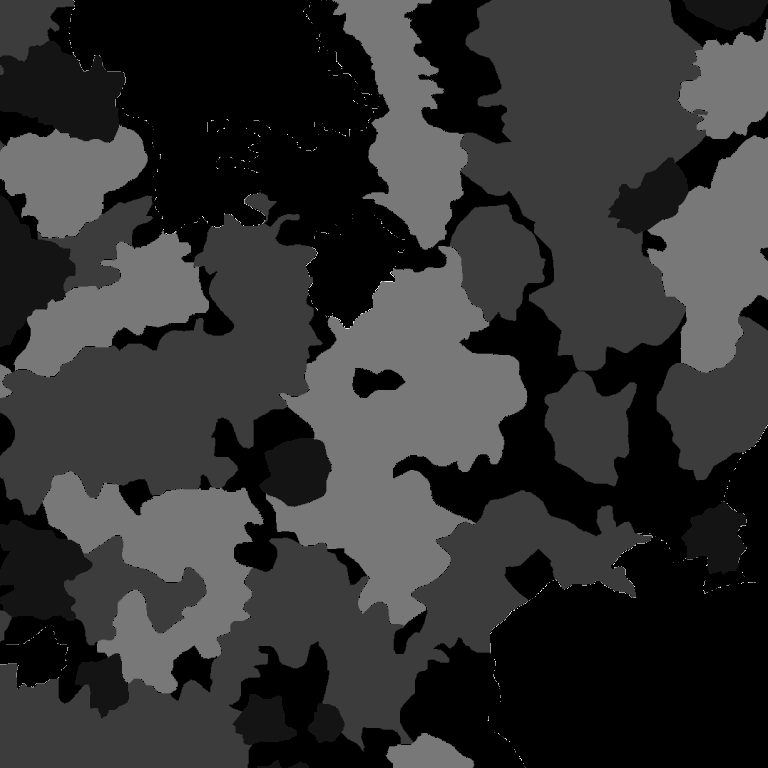

In [15]:
Image.fromarray(np.array(Image.open((label_list[3])))*20)

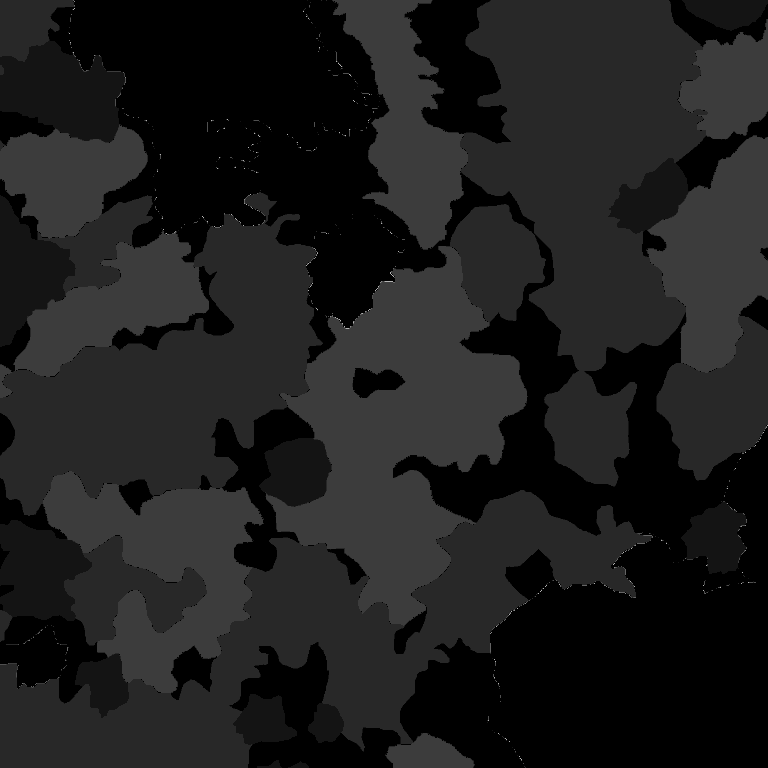

In [16]:
Image.fromarray(sp_img*20)

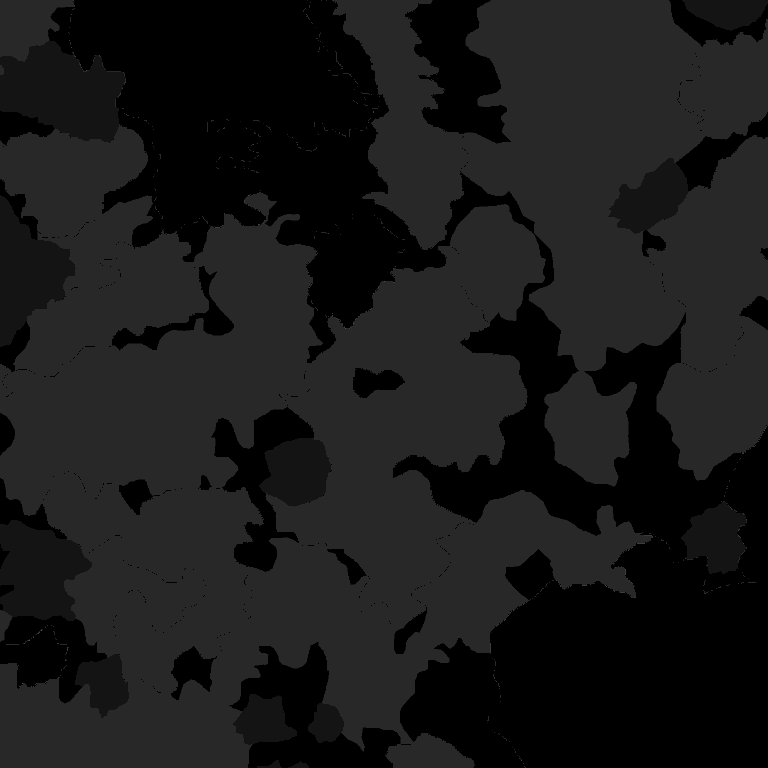

In [17]:
Image.fromarray(fam_img*20)

## Probabilities aggregation

In [18]:
preds = torch.rand((1, 14, 768, 768))
softmax = nn.LogSoftmax(dim=1) #nn.Softmax2d() 
y_hat = softmax(preds)

### Genus level

In [19]:
y_hat_list = [y_hat[:, 0, :, :],y_hat[:, 1:4, :, :],y_hat[:, 4:6, :, :],y_hat[:, 6, :, :],y_hat[:, 7, :, :], y_hat[:, 8, :, :], y_hat[:, 9, :, :],y_hat[:, 10, :, :],y_hat[:, 11, :, :]
,y_hat[:, 12, :, :], y_hat[:, 13, :, :]]

In [20]:
for i, tensor in enumerate(y_hat_list):
    if len(tensor.shape) == 3:
        y_hat_list[i] = tensor.unsqueeze(1)
    print(tensor.shape)

torch.Size([1, 768, 768])
torch.Size([1, 3, 768, 768])
torch.Size([1, 2, 768, 768])
torch.Size([1, 768, 768])
torch.Size([1, 768, 768])
torch.Size([1, 768, 768])
torch.Size([1, 768, 768])
torch.Size([1, 768, 768])
torch.Size([1, 768, 768])
torch.Size([1, 768, 768])
torch.Size([1, 768, 768])


In [21]:
ge_sp_mapping

{1: 1,
 2: [2, 3, 4],
 3: [5, 6],
 4: 7,
 5: 8,
 6: 9,
 7: 10,
 8: 11,
 9: 12,
 10: 13,
 11: 14}

In [22]:
def aggregate_probabilites(tensor_list):
    first_el = tensor_list[0]
    if len(first_el.shape) == 4 and first_el.shape[1] > 1:
            first_el = torch.sum(first_el, dim=1).unsqueeze(1)

    for tensor in y_hat_list[1:]:
        if len(tensor.shape) == 4 and tensor.shape[1] > 1:
            tensor = torch.sum(tensor, dim=1).unsqueeze(1)
        first_el = torch.cat((first_el, tensor), dim=1)
    return first_el

In [23]:
sp_tensor = aggregate_probabilites(y_hat_list)

In [24]:
sp_tensor.shape

torch.Size([1, 11, 768, 768])

In [25]:
print(print(sp_tensor.sum(1)))

tensor([[[-37.5506, -37.6991, -37.4220,  ..., -37.4855, -37.4066, -37.3186],
         [-37.6034, -37.4572, -37.6428,  ..., -37.3591, -37.8006, -37.7853],
         [-37.6374, -37.5842, -37.3989,  ..., -37.5589, -37.4889, -37.6028],
         ...,
         [-37.4531, -37.7999, -37.4906,  ..., -37.5646, -37.3306, -37.4322],
         [-37.4706, -37.5696, -37.5055,  ..., -37.4378, -37.4557, -37.2901],
         [-37.6603, -37.5226, -37.3923,  ..., -37.3896, -37.4362, -37.6500]]])
None


### Family level

In [26]:
conifer_fa = sp_tensor[:, 0, :, :] + sp_tensor[:, 6, :, :] + sp_tensor[:, 7, :, :] + sp_tensor[:, 9, :, :] + sp_tensor[:, 10, :, :]
nonconifera_fa = sp_tensor[:, 1, :, :] + sp_tensor[:, 2, :, :] + sp_tensor[:, 3, :, :] + sp_tensor[:, 8, :, :] 
palm_fa = sp_tensor[:, 4, :, :]
dead_fa = sp_tensor[:, 5, :, :]

family_tensor_list = [conifer_fa, nonconifera_fa, palm_fa, dead_fa]

In [27]:
for i, tensor in enumerate(family_tensor_list):
    if len(tensor.shape) == 3:
        family_tensor_list[i] = tensor.unsqueeze(1)
    print(tensor.shape)

torch.Size([1, 768, 768])
torch.Size([1, 768, 768])
torch.Size([1, 768, 768])
torch.Size([1, 768, 768])


In [28]:
# fa_tensor = aggregate_probabilites(family_tensor_list)

In [29]:
fa_tensor = torch.cat((family_tensor_list[0], family_tensor_list[1], family_tensor_list[2], family_tensor_list[3]), dim=1)

In [30]:
fa_tensor.shape

torch.Size([1, 4, 768, 768])

In [35]:
print(print(fa_tensor.sum(1)))

tensor([[[-37.5506, -37.6991, -37.4220,  ..., -37.4855, -37.4066, -37.3186],
         [-37.6034, -37.4572, -37.6428,  ..., -37.3590, -37.8006, -37.7853],
         [-37.6374, -37.5842, -37.3989,  ..., -37.5589, -37.4889, -37.6028],
         ...,
         [-37.4531, -37.7999, -37.4906,  ..., -37.5646, -37.3306, -37.4322],
         [-37.4706, -37.5696, -37.5055,  ..., -37.4378, -37.4557, -37.2901],
         [-37.6603, -37.5226, -37.3923,  ..., -37.3896, -37.4362, -37.6500]]])
None


### Test Loss Calculation w/ Log-Softmax+NLL Loss

### In implementation for the loss, will need to add the 0th channel (output will have 15 channels)

In [36]:
spe_target_tensor = torch.tensor(np.array(Image.open(label_list[1]))).unsqueeze(0)

In [37]:
gen_target_tensor = torch.tensor(np.array(sp_img)).unsqueeze(0)
fam_target_tensor = torch.tensor(np.array(fam_img)).unsqueeze(0) 

In [38]:
print(torch.unique(spe_target_tensor), torch.unique(gen_target_tensor), torch.unique(fam_target_tensor))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=torch.uint8) tensor([0, 1, 2, 3, 4, 5, 6, 7, 9], dtype=torch.uint8) tensor([0, 1, 2, 3, 4], dtype=torch.uint8)


In [39]:
spe_preds = y_hat
gen_preds = sp_tensor
fam_preds = fa_tensor

In [40]:
loss_sp = nn.NLLLoss()
loss_ge = nn.NLLLoss()
loss_fa = nn.NLLLoss()

In [41]:
print(spe_preds.shape, spe_target_tensor.shape)
print(gen_preds.shape, gen_target_tensor.shape)
print(fam_preds.shape, fam_target_tensor.shape)

torch.Size([1, 14, 768, 768]) torch.Size([1, 768, 768])
torch.Size([1, 11, 768, 768]) torch.Size([1, 768, 768])
torch.Size([1, 4, 768, 768]) torch.Size([1, 768, 768])


In [42]:
output_sp = loss_sp(spe_preds, spe_target_tensor.long())
output_ge = loss_ge(gen_preds, gen_target_tensor.long())
output_fa = loss_fa(fam_preds, fam_target_tensor.long())

In [43]:
print(output_ge, output_ge)

tensor(3.9690) tensor(3.9690)


### Generating three level labels

In [25]:
train_labels_path = '/home/mila/v/venkatesh.ramesh/scratch/tree_data/dataset_myriam_split_hierarchical/test/labels'
save_path_genus = '/home/mila/v/venkatesh.ramesh/scratch/tree_data/dataset_myriam_split_hierarchical/test/labels_genus'
save_path_family = '/home/mila/v/venkatesh.ramesh/scratch/tree_data/dataset_myriam_split_hierarchical/test/labels_family'

In [26]:
hierarchical_label_list = glob.glob(train_labels_path + '/**/*.png', recursive=True)

In [27]:
# print(hierarchical_label_list[0].replace('labels', 'labels_genus'))
len(hierarchical_label_list)

280

In [28]:
for item in tqdm(hierarchical_label_list):
    sp_img, fam_img = create_level_masks(item)
    sp_img.save(item.replace('labels', 'labels_genus'))
    fam_img.save(item.replace('labels', 'labels_family'))

100%|██████████| 280/280 [00:08<00:00, 34.66it/s]


In [81]:
hierarchical_label_list[100]

'/home/mila/v/venkatesh.ramesh/scratch/tree_data/dataset_myriam_split_hierarchical/train/labels/zone2/1234948_1492258.png'

In [82]:
x1 = Image.open('/home/mila/v/venkatesh.ramesh/scratch/tree_data/dataset_myriam_split_hierarchical/train/labels/zone2/1234948_1492258.png')
x2 = Image.open('/home/mila/v/venkatesh.ramesh/scratch/tree_data/dataset_myriam_split_hierarchical/train/labels_genus/zone2/1234948_1492258.png')
x3 = Image.open('/home/mila/v/venkatesh.ramesh/scratch/tree_data/dataset_myriam_split_hierarchical/train/labels_family/zone2/1234948_1492258.png')